In [1]:
pip install -U scikit-learn statsmodels Kaggle opencv-python tensorflow sklearn.ensemble

  Using cached statsmodels-0.13.2-cp39-cp39-win_amd64.whl (9.1 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement sklearn.ensemble (from versions: none)
ERROR: No matching distribution found for sklearn.ensemble


In [2]:
pip install sklearn.utils


  Created wheel for sklearn.utils: filename=sklearn_utils-0.0.15-py3-none-any.whl size=27890 sha256=855a414a490ecc14e0440cb5a07e18a4e1e678256907af6d1f5af7da439bc1d0
  Stored in directory: c:\users\ddegroot\appdata\local\pip\cache\wheels\ae\aa\20\75c06f64979aca41815d1fbdcc71599330da9b60cc4f8de0b2
Successfully built sklearn.utils


In [3]:
import numpy as np
from numpy import argmax
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
import pickle
from statsmodels.tools import categorical
from skimage.filters import prewitt_h,prewitt_v
from sklearn.neighbors import KNeighborsClassifier
from keras.models import load_model
#import kaggle
#from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile
from PIL import Image
from sklearn.metrics import plot_confusion_matrix, multilabel_confusion_matrix, roc_auc_score
from sklearn.svm import LinearSVC
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

FishCategories = ["Black Sea Sprat", "Gilt-Head Bream", "Hourse Mackerel", "Red Mullet", "Red Sea Bream", "Sea Bass", "Shrimp","Striped Red Mullet", "Trout"]


In [4]:
#{"username":"dashdg7","key":"8d15678f2d374d39b3fd6764ec02ec4d"}
# Gets the Fish Dataset from kaggle and downloads it to the working directory
def DownloadDataset():
    os.environ['KAGGLE_USERNAME'] = 'dashdg7'
    os.environ['KAGGLE_KEY'] = '8d15678f2d374d39b3fd6764ec02ec4d'
    api = KaggleApi()
    print("Authenticating API")
    api.authenticate()
    print("Downloading Dataset to Working Directory")
    print("This could take a few minutes.")
    api.dataset_download_file("crowww/a-large-scale-fish-dataset", file_name = '')
    with zipfile.ZipFile(os.path.join(os.getcwd (),'archive.zip'), 'r') as zipref:
        for file in zipref.namelist():
            if file.startswith('Fish_Dataset/Fish_Dataset'):
                archive.extract(file, os.getcwd())
    print("Download Complete")

#Runs through the zip folder and extracts on the images   
def GetData ():
    RawColor = []
    RawBW = []
    ImageLabel = []
    FishPosition = []
    counter = 0
    print("Getting Images")
    with zipfile.ZipFile(os.path.join(os.getcwd(),'archive.zip'), 'r') as zipref:
        for imagepath in zipref.namelist():
            if (imagepath.__contains__('GT')):
                pass
            elif (imagepath.__contains__('NA_Fish_Dataset')):
                pass
            elif (imagepath.__contains__('png')): #Text was img
                for FishType in FishCategories:
                    if imagepath.__contains__(FishType):
                        fishcategory = FishType
                        FishNumber = FishCategories.index(FishType)
                OriginalImage = Image.open(zipref.open(imagepath))
                OriginalImagePixelBGR = np.array(OriginalImage)
                ImageLabel.append(fishcategory)
                FishPosition.append(FishNumber)
                RawBW.append(cv2.cvtColor(OriginalImagePixelBGR, cv2.COLOR_BGR2GRAY))
               # ResizedImage = Resize(OriginalImagePixelBGR,75,75)
               # ResizedImagePixelBGR = np.array(ResizedImage)
                RawColor.append(OriginalImagePixelBGR)    
                if (counter + 1) % 500==0:
                    print("Retrieved",counter + 1,"Images of 9000")
                elif counter == 0:
                    print("Retrieved",counter,"Images of 9000")
                counter = counter + 1
    return np.array(RawColor), np.array(ImageLabel),np.array(RawBW), np.array(FishPosition)

#simple function for resizing images
def Resize(image_,w,h):
    newsize = (w, h)
    return cv2.resize(image_, dsize = newsize)

# Shuffles the position of an array
def Shuffle(array):
    return random.shuffle(array)

# Gets the average color value of an image of a given color
def GetColorAverage(ColorNumber):
    col = []
    for c in range(len(ColorImages)):
        ca = np.mean(ColorImages[c][:,:,ColorNumber])
        col.append(ca)
    return np.array(col)

# Gets the average color value of an image at a given percentile for a given color
def GetColorQ(ColorNumber,pct):
    col = []
    for c in range(len(ColorImages)):
        ca = np.array(ColorImages[c][:,:,ColorNumber])
        q = np.percentile(ca, pct)
        col.append(q)
    return np.array(col)

#Saves models to the working directory
def SaveFile(Model,FileName):
    Model.save(FileName) 
    print("Saved model to disk")
 
 #Opens a model from the working directory
def OpenFile(FileName):
    return load_model(FileName)

# builds the fitted CNN model
def BuildCNN(ResizeH, ResizeW, BatchSize, Epochs, X, Y,ArrayDepth):
    #GET IMAGE LABELS
    encoder = OneHotEncoder(sparse=False)
    Y_VALUE = pd.DataFrame(Y)
    Y_VALUE = Y_VALUE.astype('category')
    Y_VALUE_CAT = pd.DataFrame(encoder.fit_transform(Y_VALUE)) 
    
    #RESIZE AND ADD BLUR TO IMAGES
    ResizedImages = []
    for i in range(len(X)):
        R_images = Resize(X[i],ResizeH,ResizeW)
        ResizedImages.append(R_images)
    ResizedImages = np.array(ResizedImages)
    
    #TRAIN TEST SPLIT
    X_train, X_test, y_train, y_test = train_test_split(ResizedImages, Y_VALUE_CAT, test_size=0.33, random_state=42)
    y_test_array = argmax(np.array(y_test), axis=-1).astype('int')
    
    #CONSTRUCT LAYERS MODEL
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(ResizeH, ResizeW, ArrayDepth)))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())

    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(9, activation = "softmax"))
    model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    #TRAIN MODEL
    model.fit(X_train, y_train, batch_size = BatchSize, epochs = Epochs)
    
    return model, X_test, y_test_array

# builds a multiclass confusion matrix
def ConfusionMatrix(yt, yh): 
    CM = np.zeros((len(FishCategories), len(FishCategories)))
    for i in range(len(yt)):
        AP = yt[i]
        PP = yh[i]
        CM[AP][PP] = CM[AP][PP] + 1
    s = sns.heatmap(CM, 
                linewidth=0.5,
                square=True, 
                cmap='viridis',
                annot=True,
                fmt= '.0f',
                xticklabels=FishCategories, 
                yticklabels=FishCategories)
    s.set(xlabel='Predicted', ylabel='Actual')
    return plt.show()

In [5]:
if os.path.exists(os.path.join(os.getcwd (),'archive.zip')):
    pass
else:
    DownloadDataset()
ColorImages, ImageLabels, GrayImage, FishPosition = GetData() 


Getting Images
Retrieved 0 Images of 9000
Retrieved 500 Images of 9000
Retrieved 1000 Images of 9000
Retrieved 1500 Images of 9000
Retrieved 2000 Images of 9000
Retrieved 2500 Images of 9000
Retrieved 3000 Images of 9000
Retrieved 3500 Images of 9000
Retrieved 4000 Images of 9000
Retrieved 4500 Images of 9000
Retrieved 5000 Images of 9000
Retrieved 5500 Images of 9000
Retrieved 6000 Images of 9000
Retrieved 6500 Images of 9000
Retrieved 7000 Images of 9000
Retrieved 7500 Images of 9000
Retrieved 8000 Images of 9000
Retrieved 8500 Images of 9000
Retrieved 9000 Images of 9000


Epoch 1/10
201/201 [==============================] - 5s 16ms/step - loss: 2.3258 - accuracy: 0.4158
Epoch 2/10
201/201 [==============================] - 3s 14ms/step - loss: 0.8209 - accuracy: 0.7033
Epoch 3/10
201/201 [==============================] - 3s 14ms/step - loss: 0.5279 - accuracy: 0.8096
Epoch 4/10
201/201 [==============================] - 3s 16ms/step - loss: 0.3814 - accuracy: 0.8678
Epoch 5/10
201/201 [==============================] - 3s 17ms/step - loss: 0.2742 - accuracy: 0.8988
Epoch 6/10
201/201 [==============================] - 3s 15ms/step - loss: 0.2428 - accuracy: 0.9114
Epoch 7/10
201/201 [==============================] - 3s 13ms/step - loss: 0.1575 - accuracy: 0.9405
Epoch 8/10
201/201 [==============================] - 3s 14ms/step - loss: 0.1952 - accuracy: 0.9270
Epoch 9/10
201/201 [==============================] - 4s 19ms/step - loss: 0.1049 - accuracy: 0.9610
Epoch 10/10
201/201 [==============================] - 4s 20ms/step - loss: 0.1421 - accura

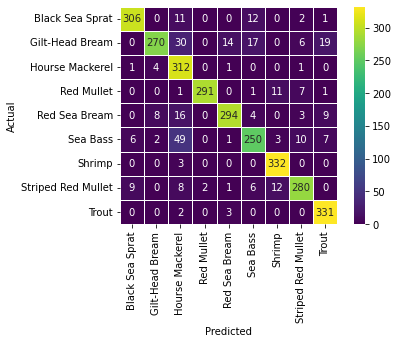

In [6]:
CNNFitted,CNNX_test, CNNY_test_label = BuildCNN(25,25,30,10,ColorImages,ImageLabels,3)
SaveFile(CNNFitted,'CNNModel.h5')
CNNFitted = OpenFile('CNNModel.h5')
PredictedPercent = CNNFitted.predict(CNNX_test)
CNNyhat = argmax(PredictedPercent, axis=-1).astype('int')
ConfusionMatrix(CNNY_test_label, CNNyhat)


C:\Users\ddegroot\AppData\Local\Temp\2/ipykernel_1312/96446330.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.imshow(np.array(IncorrectlyLabeled)[fishnumber][2])
C:\Users\ddegroot\AppData\Local\Temp\2/ipykernel_1312/96446330.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.title('Actual Label - '+str(FishCategories[np.array(IncorrectlyLabeled)[fishnumber][0]])+'\n'+


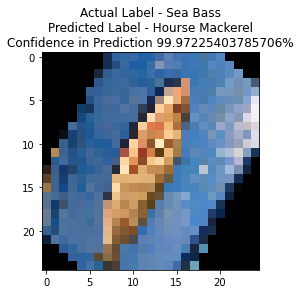

In [7]:
IncorrectlyLabeled = []
for i in range(len(CNNY_test_label)):
    if CNNY_test_label[i] != CNNyhat[i]:
        IncorrectlyLabeled.append([CNNY_test_label[i],CNNyhat[i],CNNX_test[i]])

fishnumber = 25
plt.imshow(np.array(IncorrectlyLabeled)[fishnumber][2])
plt.title('Actual Label - '+str(FishCategories[np.array(IncorrectlyLabeled)[fishnumber][0]])+'\n'+
          'Predicted Label - '+str(FishCategories[IncorrectlyLabeled[fishnumber][1]])+'\n'+
          'Confidence in Prediction ' +str(max(PredictedPercent[i]).astype('float')*100)+'%')    
plt.show()

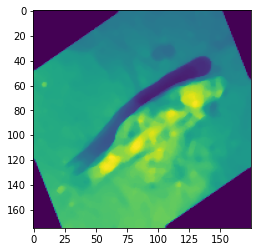

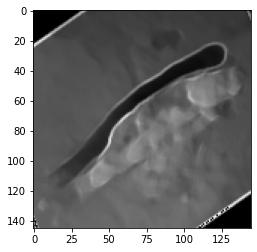

In [ ]:
resize = 175
cropl = 15
croph = resize-15
Resized = GrayImage[3500]
Resized = Resize(Resized, resize,resize)
Resized = cv2.medianBlur(Resized, 5)
Resized = cv2.medianBlur(Resized, 5)


#plt.imshow(Resized,cmap='gray')
#define the vertical filter
E = [[-1,0,1], [-2,0,2], [-1,0,1]]
NE = [[0,1,2], [-1,0,1], [-2,1,0]]
N = [[1,2,1], [0,0,0], [-1,-2,-1]]
NW = [[2,1,0], [1,0,-1], [0,-1,-2]]
W = [[-1,0,1], [2,0,-2], [1,0,-1]]
SW = [[0,-1,-2], [1,0,-1],[2,-1,0]]
S = [[-1,-2,-1], [0,0,0],[1,2,1]]
SE = [[-2,-1,0], [-1,0,1],[0,1,2]]


#read in the pinwheel image
img = Resized

#get the dimensions of the image
n,m = img.shape

#initialize the edges image
edges_img = img.copy()

#loop over all pixels in the image
for row in range(3, n-2):
    for col in range(3, m-2):
        
        #create little local 3x3 box
        local_pixels = img[row-1:row+2, col-1:col+2]
        East = E*local_pixels
        West = W*local_pixels
        North = N*local_pixels
        South = S*local_pixels
        NorthEast = NE*local_pixels
        NorthWest = NW*local_pixels
        SouthEast = SE*local_pixels
        SouthWest = SW*local_pixels
        
        Escore = East.sum()/4
        Wscore = West.sum()/4
        Nscore = North.sum()/4
        Sscore = South.sum()/4        
        NEscore = NorthEast.sum()/4
        NWscore = NorthWest.sum()/4
        SEscore = SouthEast.sum()/4
        SWscore = SouthWest.sum()/4
        
        #combine the horizontal and vertical scores into a total edge score
        edge_score = (Escore**2+Wscore**2+Nscore**2+Sscore**2+ NEscore**2+ NWscore**2 +SEscore**2+SWscore**2)**.5
        
        #insert this edge score into the edges image
        edges_img[row, col] = edge_score

#remap the values in the 0-1 range in case they went out of bounds
edges_img = edges_img/edges_img.max()

plt.imshow(Resized)
plt.show()
Crop = edges_img[range(cropl,croph),:]
Crop = Crop[:,range(cropl,croph)]
plt.imshow(Crop, cmap = "gray")
plt.show()
edges = cv2.Canny(Resized,100,200)
plt.imshow(edges, cmap = 'gray')

In [ ]:
n = 0
Colors = ['blue','orange','green','red','purple','brown','pink','gray','olive']
index = []
for j in range(9):
    for i in range(1000):
         index.append(n)
    n = n+1
ColorDim = [index,GetColorAverage(0),GetColorAverage(1),GetColorAverage(2), GetColorQ(0,25), GetColorQ(1,25), GetColorQ(2,25),GetColorQ(0,25), GetColorQ(1,25), GetColorQ(2,25)]
#ColorDimDt = pd.DateFrame(columns = ('FishPosition','RedAvg','GreenAvg','BlueAvg','Red25Q','Green25Q','Blue25Q','Red75Q','Green75Q','Blue75Q'))
ColorDimDt = pd.DataFrame(np.transpose(ColorDim))


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(ColorDimDt.loc[:, ColorDimDt.columns!=0], ColorDimDt[0], test_size=0.33, random_state=42)
y_test = np.array(y_test).astype('int')

KNN = KNeighborsClassifier(n_neighbors=17)
KNNFitted = KNN.fit(X_train, y_train)
KNNFitted.score(X_test,y_test)

KNNYhat = np.array(KNNFitted.predict(X_test)).astype('int')
KNNCM = ConfusionMatrix(y_test, KNNYhat)
KNNCM

#X, y = make_classification(n_features=3, random_state=0)
SVM = LinearSVC(random_state=0, tol=1e-5)
SVMFitted = SVM.fit(X_train, y_train)
SVMFitted.score(X_test,y_test)
SVMYhat = np.array(SVMFitted.predict(X_test)).astype('int')
SVMCM = ConfusionMatrix(y_test, SVMYhat)
SVMCM


In [ ]:

plt.scatter(ColorDimDt[1],ColorDimDt[2],c = ColorDimDt[0])
plt.xlabel("red")
plt.ylabel("green")
plt.title("Average Pixel Value")
plt.show()

plt.scatter(ColorDimDt[4],ColorDimDt[5],c = ColorDimDt[0])
plt.xlabel("red")
plt.ylabel("green")
plt.title("75Th Quartile Pixel Value")
plt.show()


In [ ]:
for i in range(9):
    plt.hist(ColorDimDt[ColorDimDt[0]==i][1],color = Colors[i],alpha = .75)
    plt.title("Average Red Pixcel Value Distribution")
plt.show()